In [1]:
library(rptR) #repeatabilities
library(lmerTest) #lmer with pvalues
library(MuMIn) #R2
library(merTools) #sim
library(dplyr) #%>%
library(boot) #bootstrap IC
library(DHARMa) #verify assumpltion of glm

Warning message:
"package 'rptR' was built under R version 3.6.3"
Warning message:
"package 'lmerTest' was built under R version 3.6.3"
Loading required package: lme4

Warning message:
"package 'lme4' was built under R version 3.6.3"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 3.6.3"

Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Warning message:
"package 'MuMIn' was built under R version 3.6.3"
Warning message:
"package 'merTools' was built under R version 3.6.3"
Loading required package: arm

Loading required package: MASS

Warning message:
"package 'MASS' was built under R version 3.6.3"

arm (Version 1.12-2, built: 2021-10-15)


Working directory is C:/Users/camil/Desktop/animals_code/PhD-AnimalWelfare/Chapter1-EarlyMovementLateHealth/MeasuringBehavior


Warning message:
"package 'dplyr' was built under R version 3.6.3

In [2]:
#install.packages("lmerTest")
#library(lmerTest)

In [3]:
citation("lmerTest")


To cite lmerTest in publications use:

Kuznetsova A, Brockhoff PB, Christensen RHB (2017). "lmerTest Package:
Tests in Linear Mixed Effects Models." _Journal of Statistical
Software_, *82*(13), 1-26. doi: 10.18637/jss.v082.i13 (URL:
https://doi.org/10.18637/jss.v082.i13).

A BibTeX entry for LaTeX users is

  @Article{,
    title = {{lmerTest} Package: Tests in Linear Mixed Effects Models},
    author = {Alexandra Kuznetsova and Per B. Brockhoff and Rune H. B. Christensen},
    journal = {Journal of Statistical Software},
    year = {2017},
    volume = {82},
    number = {13},
    pages = {1--26},
    doi = {10.18637/jss.v082.i13},
  }


library(lme4)
library(arm)
library(MuMIn)
library(tidyverse)
library(plyr)
library(broom)
library(coda)
library(grid)
library(gridExtra)
library(brms)
library(broom.mixed)
library(merTools)
library(tidybayes)
library(parallel)

# Download data

In [49]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
path_adapt = file.path(path_,'Adaptability')
df = read.csv(file.path(path_adapt,'df_MVT_4individuality_MB.csv'), header = TRUE, sep = ";")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
df$cDIB = as.integer(df$DIB_startat11)
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)
#scale: mean-centering of the environmental variable so that intercepts reflect average values for the population and ind. 
df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)
df$time = scale(df$cDIB, center=FALSE, scale=sd(df$cDIB, na.rm = TRUE)) #as not centering, we need to add this
df$time2 = poly(df$time, degree=2,raw=TRUE)[,2]
df$time3 = poly(df$time, degree=3,raw=TRUE)[,3]
df$avgDIB_scale = scale(df$avgDIB, center=TRUE, scale=TRUE)
df$InitialWeight_scale = scale(df$InitialWeight, center=TRUE, scale=TRUE)

#WG var
df$perc_1_Zone_while_WG_open = as.integer(df$perc_1_Zone_while_WG_open)
df$perc_NOT1_Zone_while_WG_open = 100-df$perc_1_Zone_while_WG_open
df$in_WG_15mnAfterOpening = as.integer(df$in_WG_15mnAfterOpening)

#top tier var
df$perc_duration_5_Zone = as.integer(df$perc_duration_5_Zone)
df$perc_duration_NOT5_Zone = 100-df$perc_duration_5_Zone

#vertical travel distance
df$vertical_travel_distance_perh_int = as.integer(df$vertical_travel_distance_perh)
#stay in nestbox zone
df$nbr_stays_4_Zone_perh_int = as.integer(df$nbr_stays_4_Zone_perh)


#setting reference group
contrasts(df$Treatment)
df <- df %>% mutate(Treatment = relevel(Treatment, ref = "TRAN"))
contrasts(df$Treatment)

contrasts(df$CLASS)
df <- df %>% mutate(CLASS = relevel(CLASS, ref = "LEXP"))
contrasts(df$CLASS)

print(dim(df))
summary(df)
head(df,3)

,TRAN
OFH,0
TRAN,1


,OFH
TRAN,0
OFH,1


,MEXP,REXP
LEXP,0,0
MEXP,1,0
REXP,0,1


,MEXP,REXP
LEXP,0,0
MEXP,1,0
REXP,0,1


[1] 3230   38


     HenID           DIB         CLASS          PenID     temperature_C_avg
 hen_116:  43   Min.   :11.00   LEXP: 965   pen10  :504   Min.   : 4.000   
 hen_124:  43   1st Qu.:23.00   MEXP:1379   pen11  :504   1st Qu.: 8.667   
 hen_127:  43   Median :33.00   REXP: 886   pen8   :430   Median :11.000   
 hen_136:  43   Mean   :33.59               pen9   :429   Mean   :10.838   
 hen_147:  43   3rd Qu.:44.00               pen4   :388   3rd Qu.:12.667   
 hen_151:  43   Max.   :54.00               pen5   :363   Max.   :19.333   
 (Other):2972                               (Other):612                    
  tobeusedPCA     InitialWeight  Treatment   perc_duration_5_Zone
 Min.   :0.0000   Min.   :1046   TRAN:1616   Min.   :  0.00      
 1st Qu.:0.0000   1st Qu.:1130   OFH :1614   1st Qu.: 11.00      
 Median :0.0000   Median :1164               Median : 33.00      
 Mean   :0.1734   Mean   :1169               Mean   : 39.21      
 3rd Qu.:0.0000   3rd Qu.:1200               3rd Qu.: 66.00   

,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,temperature_C_avg_scale,time,time2,time3,avgDIB_scale,InitialWeight_scale,perc_NOT1_Zone_while_WG_open,perc_duration_NOT5_Zone,vertical_travel_distance_perh_int,nbr_stays_4_Zone_perh_int
,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<dbl>,<fct>,<int>,<dbl>,...,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<int>,<int>
1,hen_134,11,MEXP,pen10,11.50000,1,1112,TRAN,100,0,...,0.2080966,0.0000000,0.000000000,0.0000000000,-0.3677554,-0.9142959,100,0,0,0
2,hen_134,12,MEXP,pen10,10.16667,0,1112,TRAN,86,0,...,-0.2112122,0.0811546,0.006586069,0.0005344898,-0.3677554,-0.9142959,100,14,0,0
3,hen_134,13,MEXP,pen10,9.00000,0,1112,TRAN,100,0,...,-0.5781073,0.1623092,0.026344277,0.0042759186,-0.3677554,-0.9142959,100,0,0,0


In [1]:
#head(df[c('perc_NOT1_Zone_while_WG_open','perc_1_Zone_while_WG_open')],30)

In [6]:
length(unique(df[['HenID']]))

[1] 80

# Repeatabilities

In [7]:
#to try: perc_duration_5_Zone, perc_1_Zone_while_WG_open, vertical_travel_distance_perh, nbr_stays_4_Zone_perh, sleepingdown
#spae-use behavior: log ratio of duration in a zone/duration in a baseline zone, to use gaussian family, does not work because 
#some/to many individuals never moved from zone 5

In [8]:
nboot_ = 100
npermut_ = 2

### vertical travel distance

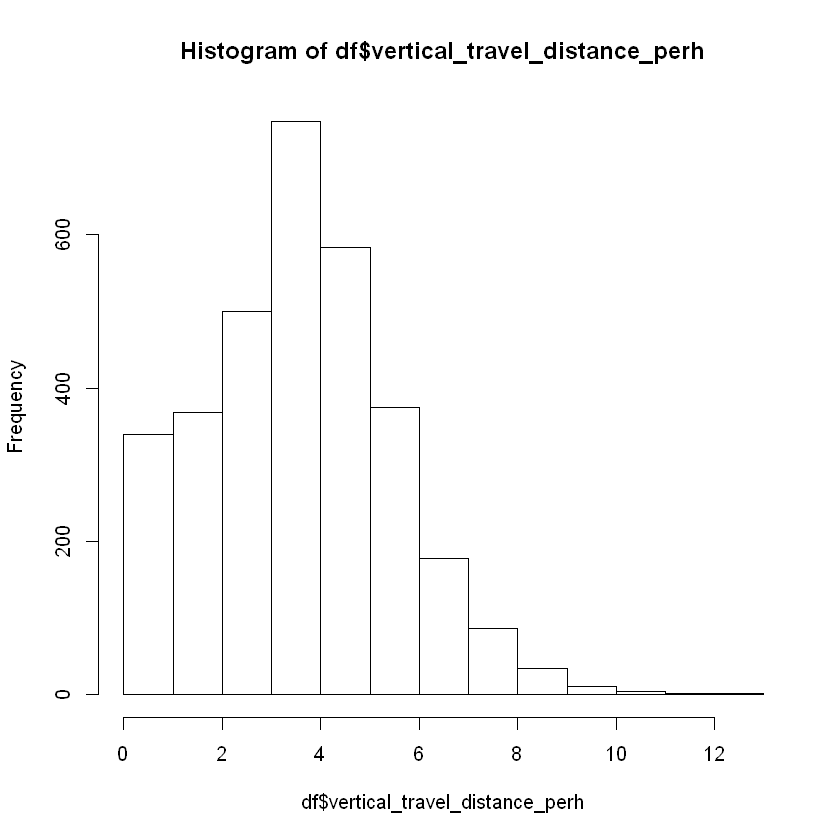

In [9]:
hist(df$vertical_travel_distance_perh)

Bootstrap Progress:
Permutation Progress for HenID :


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.378
SE = 0.041
CI = [0.285, 0.442]
P  = 1.24e-270 [LRT]
     0.5 [Permutation]



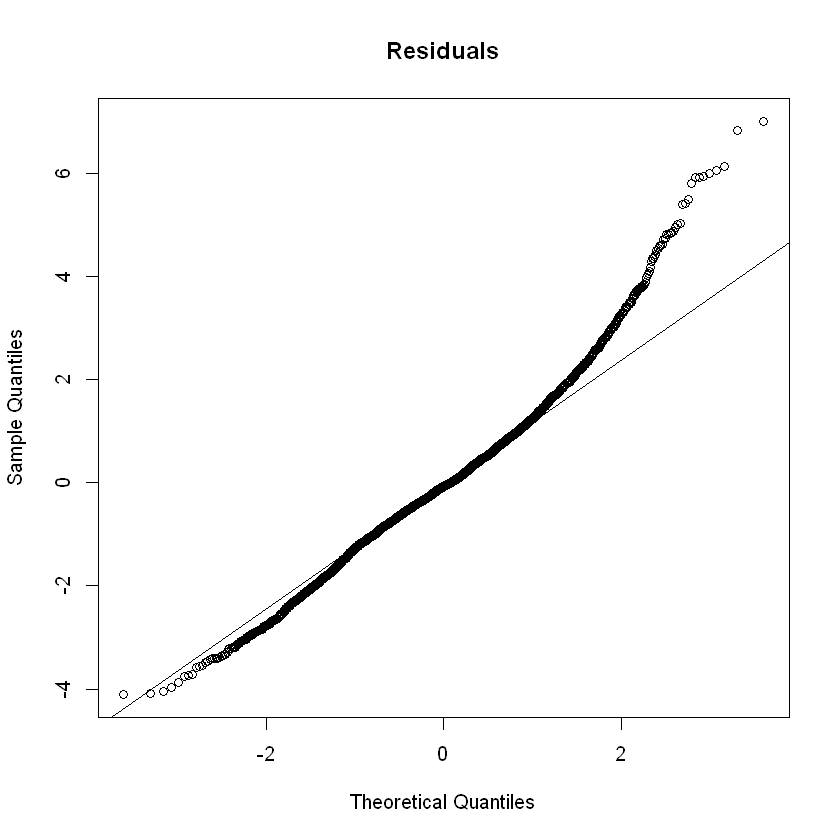

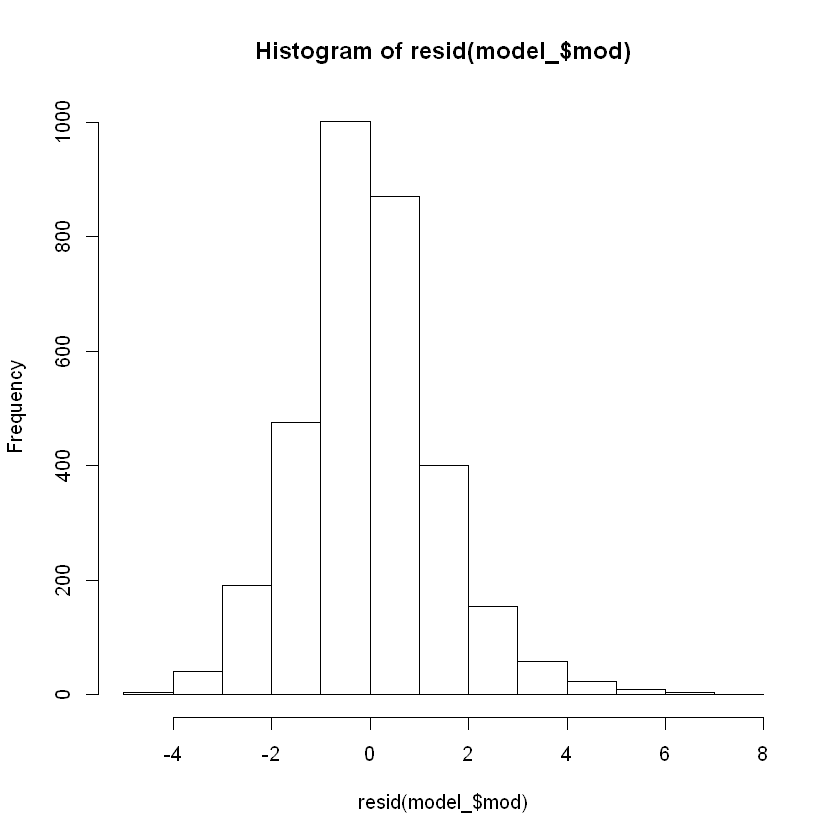

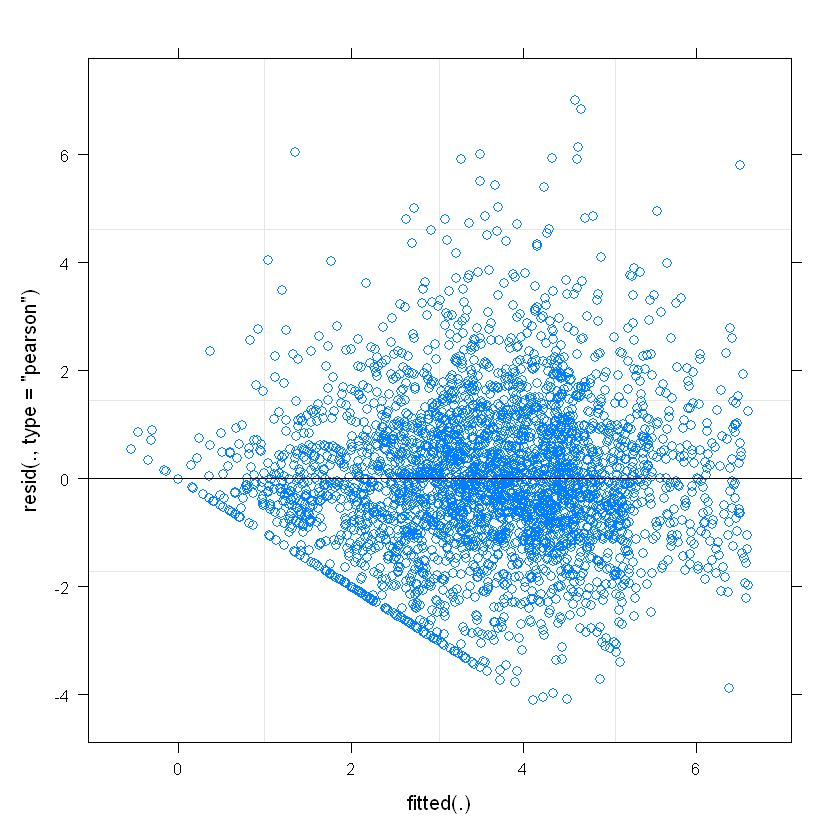

In [10]:
#poisson and sqrt are worse
set.seed(1234)
model_ = rpt(vertical_travel_distance_perh ~ time + time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID),
               grname=c("HenID"), datatype = "Gaussian", data=df, adjusted =TRUE, nboot = nboot_, npermut = npermut_) 
print(model_)
#par(mfrow = c(2, 2))
###### normally distributed residuals
qqnorm(resid(model_$mod), main = "Residuals")
qqline(resid(model_$mod))
hist(resid(model_$mod))
######check homogeneity of variance (residuals has constant variance)
#variance of the residuals is equal across groups. Even spread around the centered line?
plot(model_$mod)

In [20]:
head(df,3)

,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,temperature_C_avg_scale,time,time2,time3,avgDIB_scale,InitialWeight_scale,perc_NOT1_Zone_while_WG_open,perc_duration_NOT5_Zone,vertical_travel_distance_perh_int,nbr_stays_4_Zone_perh_int
,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<dbl>,<fct>,<int>,<dbl>,...,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<int>,<int>
1,hen_134,11,MEXP,pen10,11.50000,1,1112,TRAN,100,0,...,0.2080966,0.0000000,0.000000000,0.0000000000,-0.3677554,-0.9142959,100,0,0,0
2,hen_134,12,MEXP,pen10,10.16667,0,1112,TRAN,86,0,...,-0.2112122,0.0811546,0.006586069,0.0005344898,-0.3677554,-0.9142959,100,14,0,0
3,hen_134,13,MEXP,pen10,9.00000,0,1112,TRAN,100,0,...,-0.5781073,0.1623092,0.026344277,0.0042759186,-0.3677554,-0.9142959,100,0,0,0


### perc_duration_5_Zone

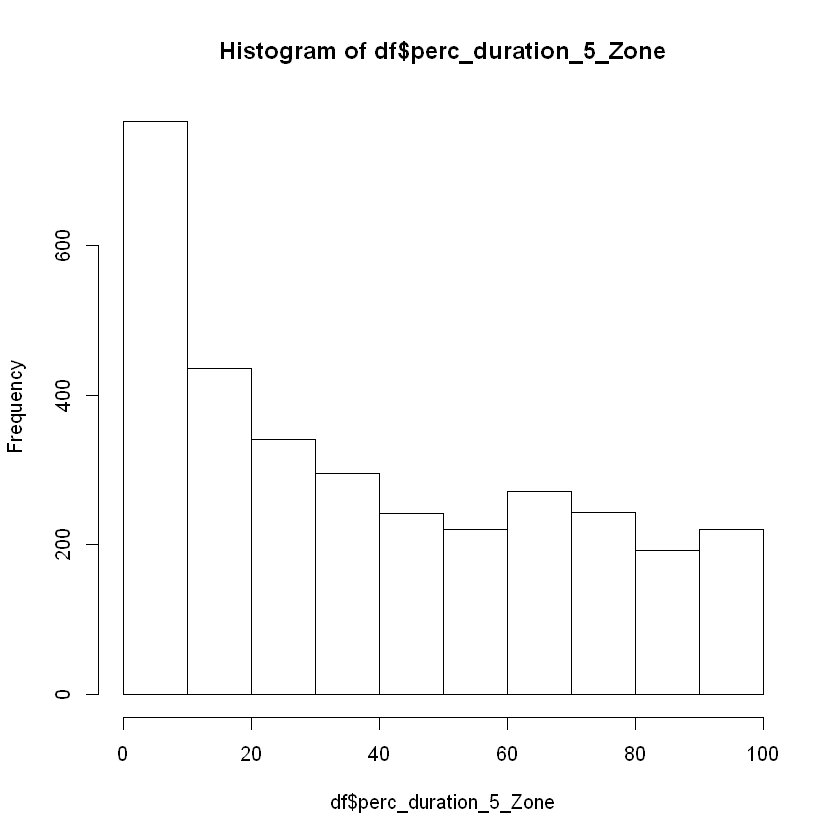

In [28]:
hist(df$perc_duration_5_Zone)

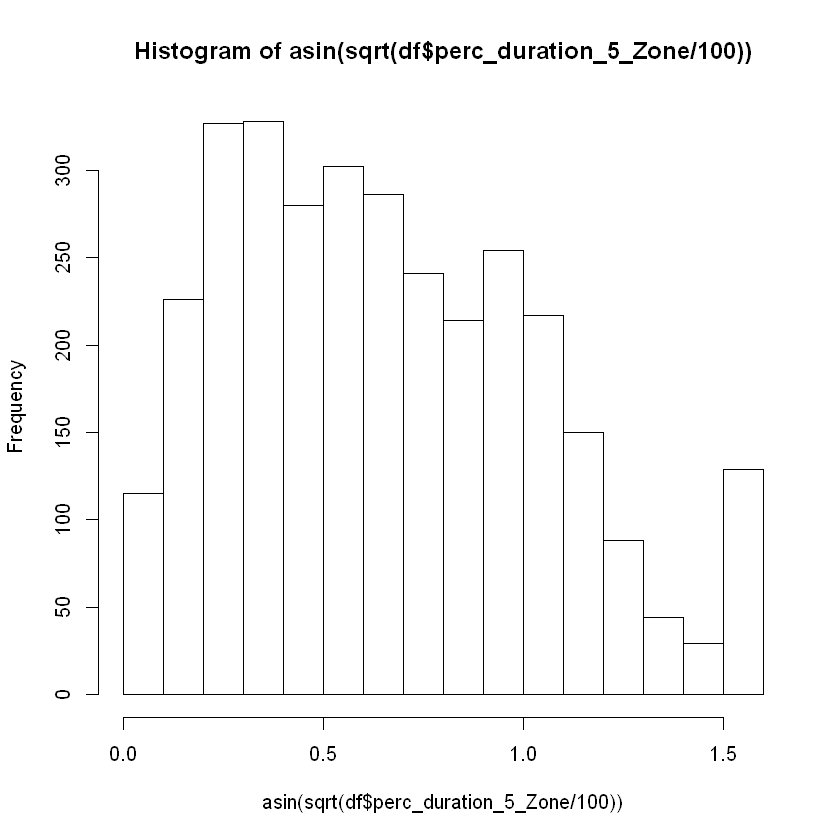

In [25]:
hist(asin(sqrt(df$perc_duration_5_Zone/100)))

Bootstrap Progress:
Permutation Progress for HenID :


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.438
SE = 0.041
CI = [0.361, 0.503]
P  = 0 [LRT]
     0.5 [Permutation]



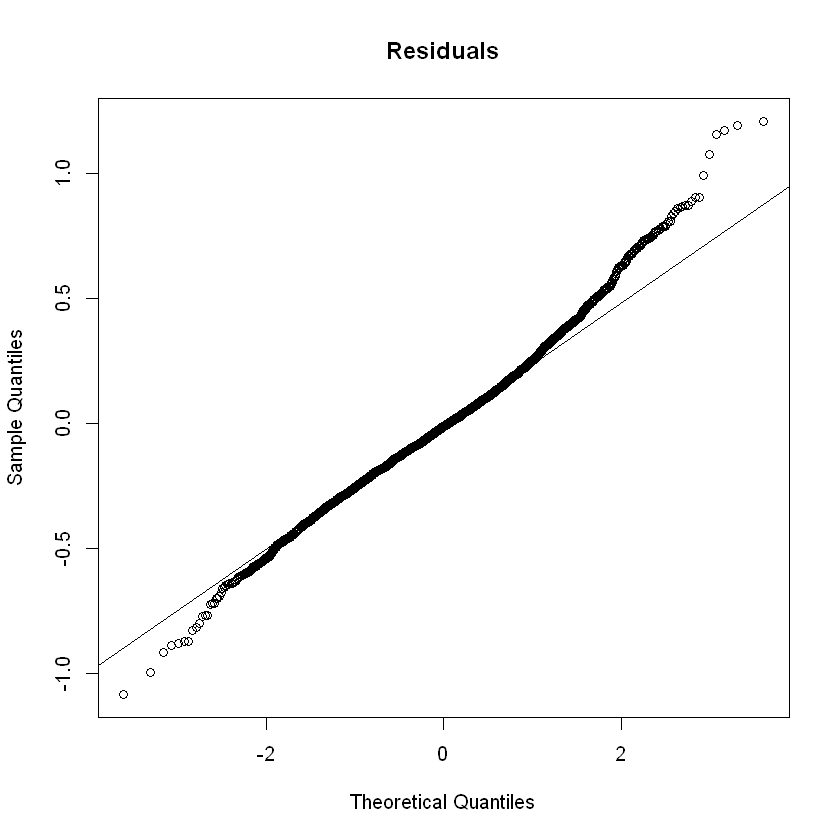

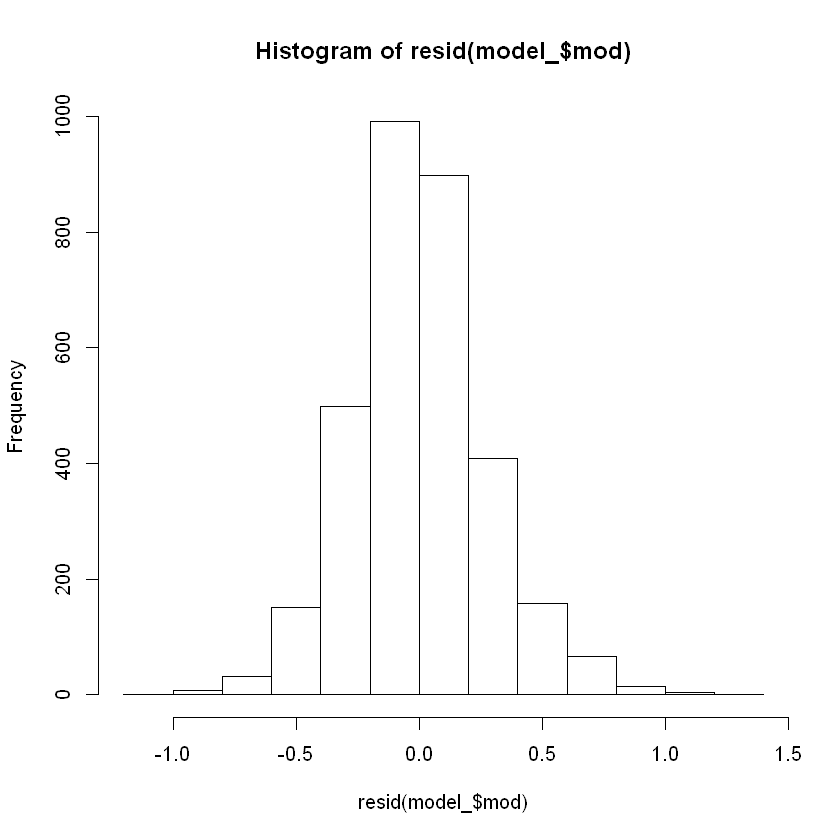

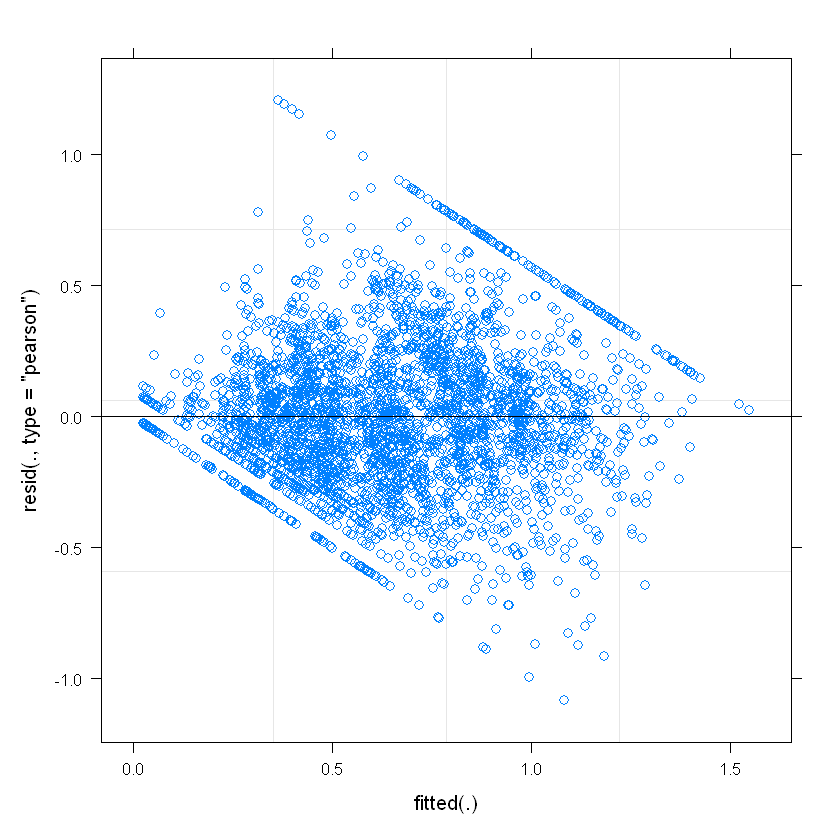

In [13]:
model_ = rpt(asin(sqrt(perc_duration_5_Zone/100)) ~ time + time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID),
               grname=c("HenID"), datatype = "Gaussian", data=df, adjusted =TRUE, nboot = nboot_, npermut = npermut_) 
print(model_)
#par(mfrow = c(2, 2))
###### normally distributed residuals
qqnorm(resid(model_$mod), main = "Residuals")
qqline(resid(model_$mod))
hist(resid(model_$mod))
######check homogeneity of variance (residuals has constant variance)
#variance of the residuals is equal across groups. Even spread around the centered line?
plot(model_$mod)

#doe snot cvg and take ages
set.seed(1234)
mod_ = rpt(cbind(perc_duration_5_Zone, perc_duration_NOT5_Zone) ~ time + time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID),
               grname=c("HenID"), datatype = "Proportion", data=df, adjusted =TRUE, nboot = nboot_, npermut = npermut_) 
mod_
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)

### perc_1_Zone_while_WG_open

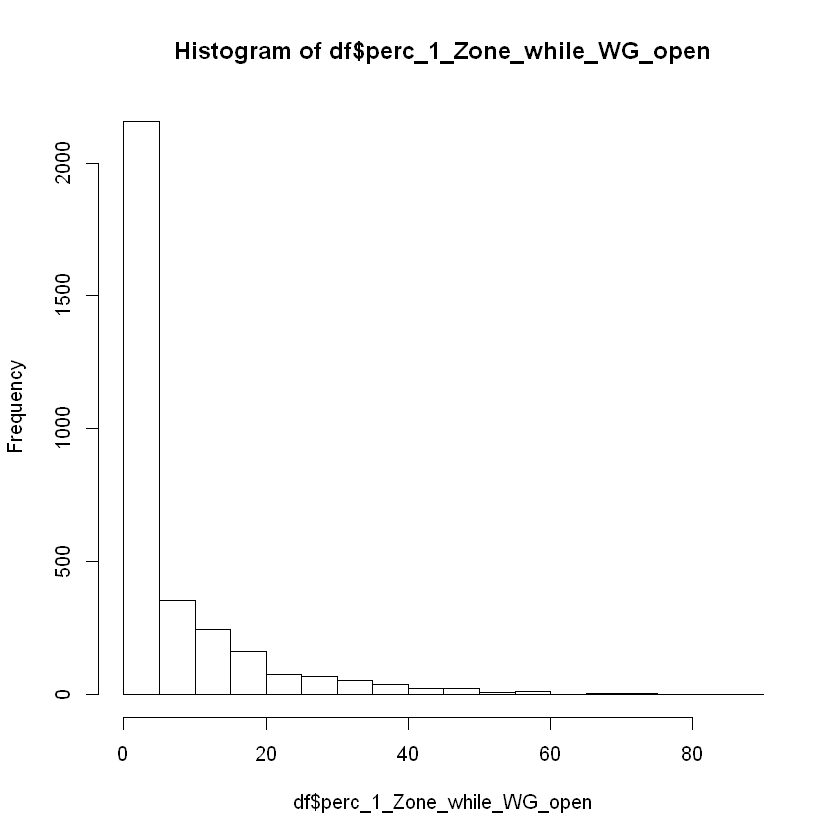

In [42]:
hist(df$perc_1_Zone_while_WG_open)

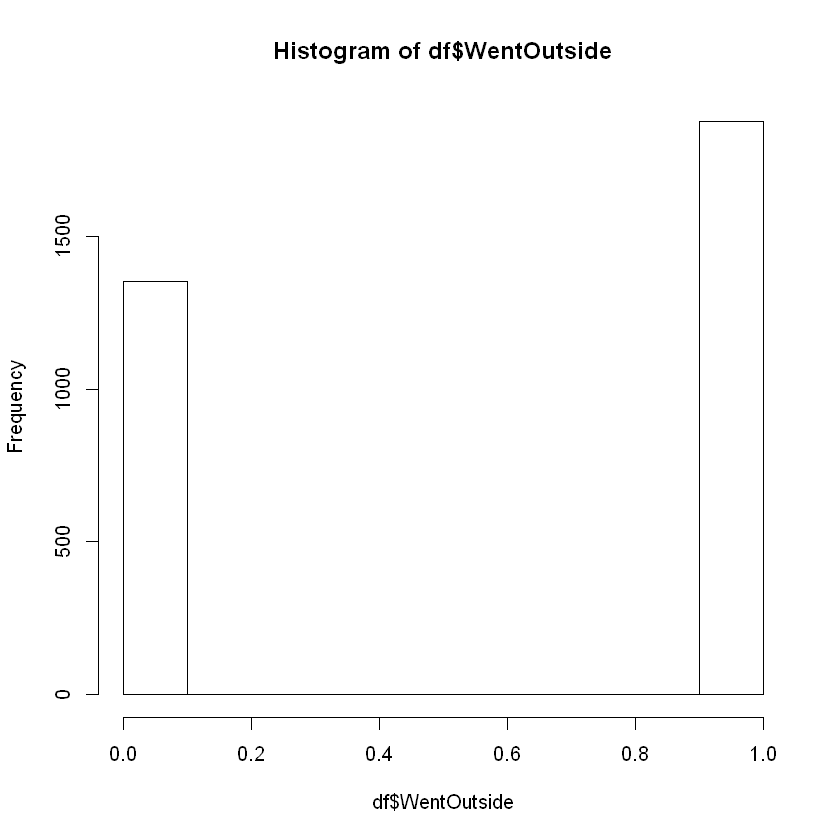

In [50]:
hist(df$WentOutside)

Bootstrap Progress:
Permutation Progress for HenID:




Repeatability estimation using the glmm method and logit link 

Repeatability for HenID
--------------------------------
Link-scale approximation:
R  = 0.514
SE = 0.042
CI = [0.407, 0.568]
P  = 2.44e-246 [LRT]
     0.5 [Permutation]

Original-scale approximation:
R  = 0.182
SE = 0.018
CI = [0.163, 0.224]
P  = 2.44e-246 [LRT]
     0.5 [Permutation]


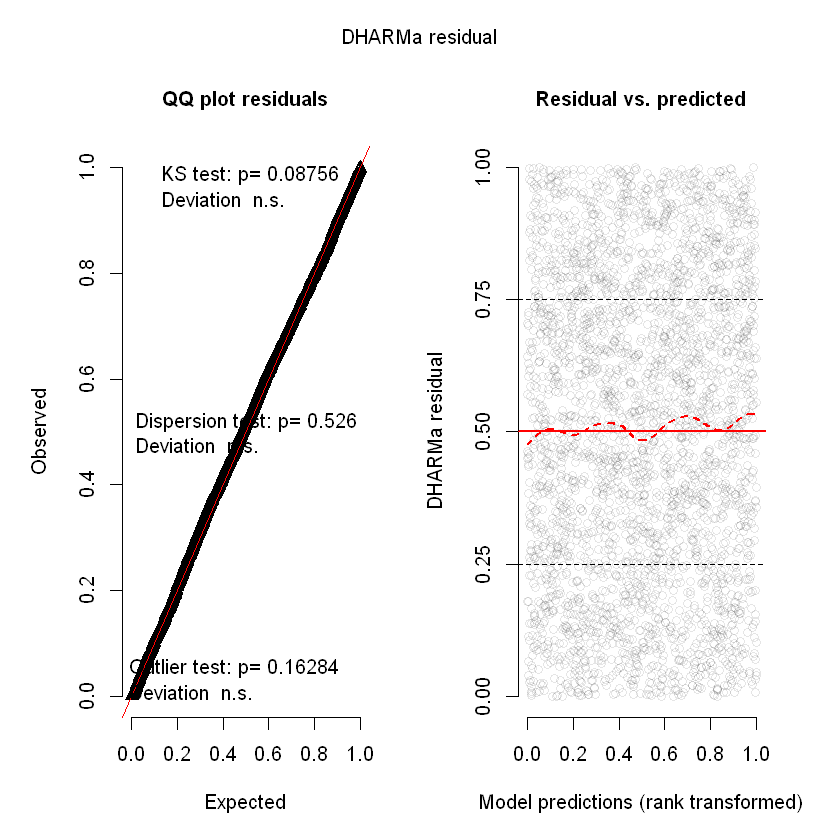

In [51]:
set.seed(1234)
mod_ = rpt(WentOutside ~ time + time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID),
               grname=c("HenID"), datatype = "Binary", data=df, adjusted =TRUE, nboot = nboot_, npermut = npermut_) 
mod_
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)

Bootstrap Progress:
Permutation Progress for HenID :


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.433
SE = 0.046
CI = [0.338, 0.515]
P  = 0 [LRT]
     0.5 [Permutation]



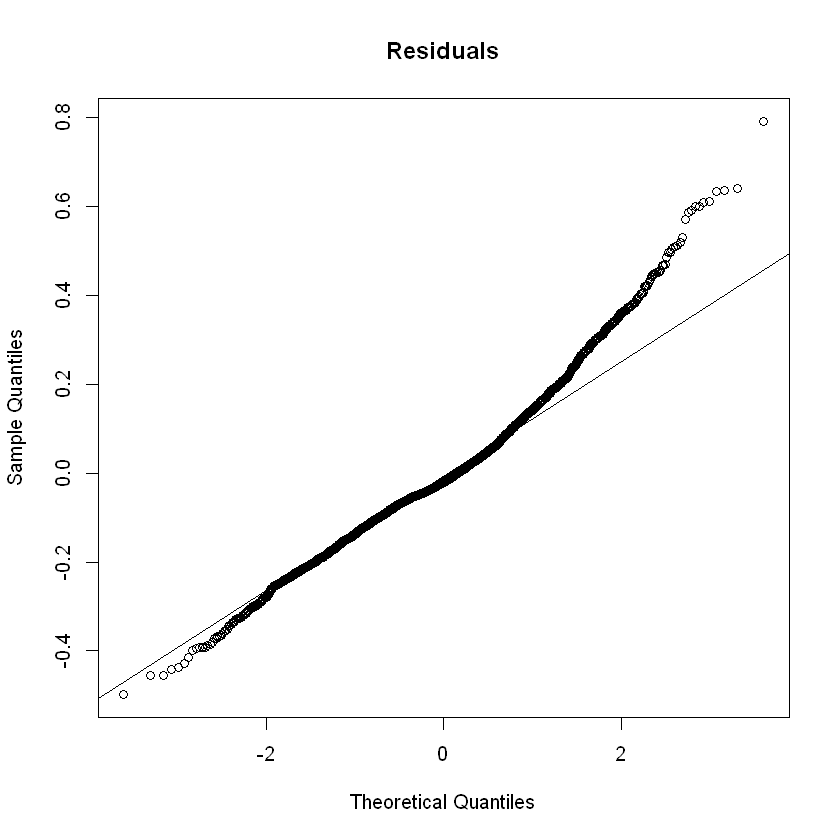

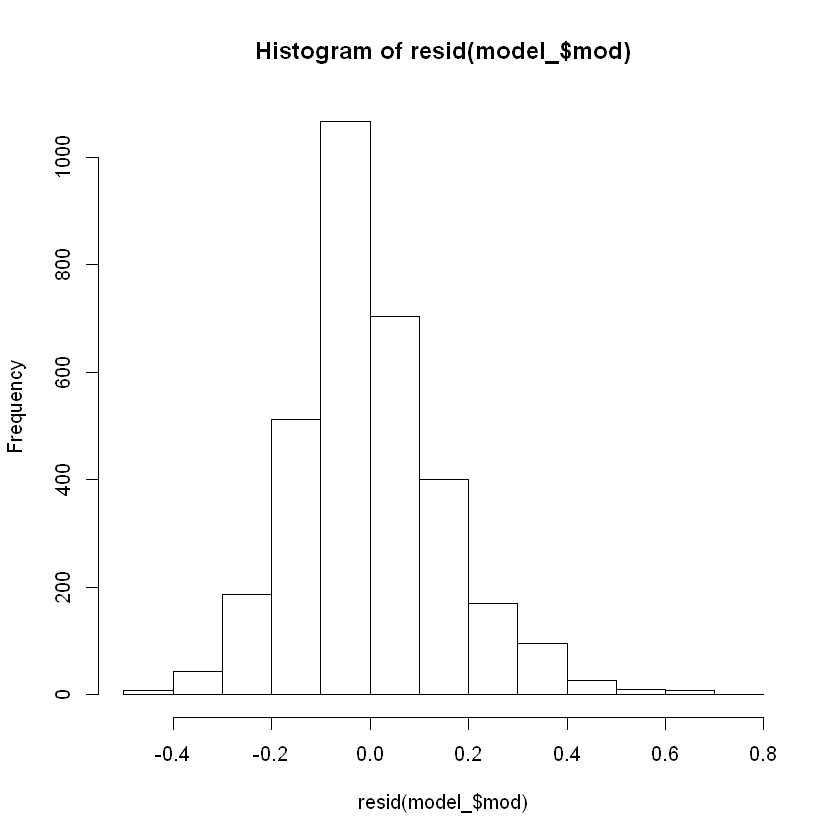

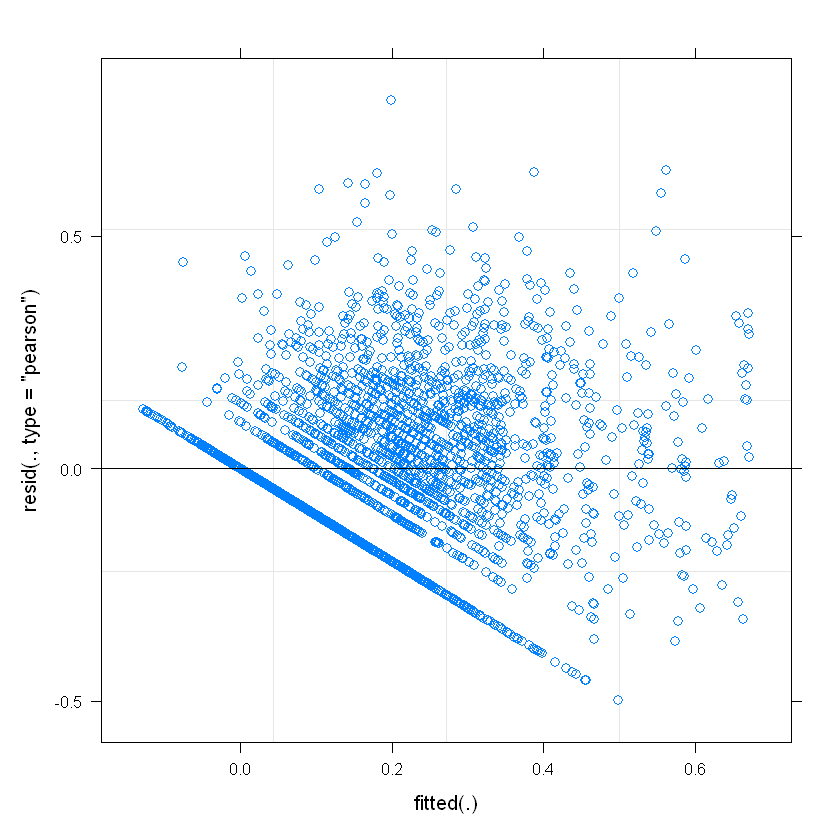

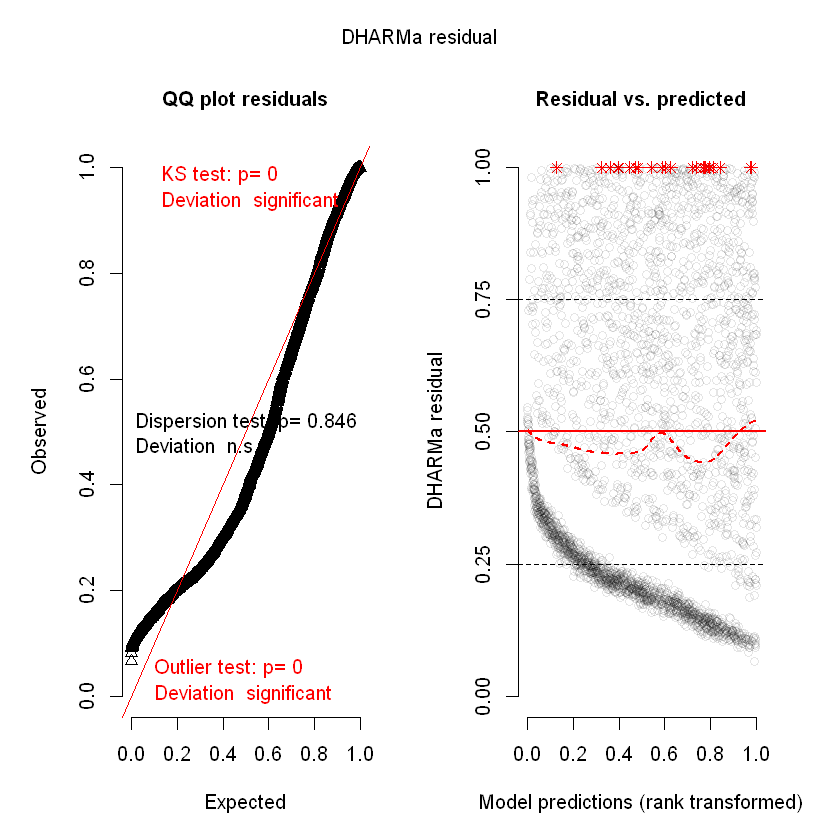

In [15]:
#DOES NOT FIT 
model_ = rpt(asin(sqrt(perc_1_Zone_while_WG_open/100)) ~ time+ time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID),
               grname=c("HenID"), datatype = "Gaussian", data=df, adjusted =TRUE, nboot = nboot_, npermut = npermut_) 
print(model_)
#par(mfrow = c(2, 2))
###### normally distributed residuals
qqnorm(resid(model_$mod), main = "Residuals")
qqline(resid(model_$mod))
hist(resid(model_$mod))
######check homogeneity of variance (residuals has constant variance)
#variance of the residuals is equal across groups. Even spread around the centered line?
plot(model_$mod)

sim_res = simulateResiduals(model_$mod, n=1000)
plot(sim_res)

### sleeping down

Bootstrap Progress:
Permutation Progress for HenID:




Repeatability estimation using the glmm method and logit link 

Repeatability for HenID
--------------------------------
Link-scale approximation:
R  = 0.191
SE = 0.043
CI = [0.117, 0.279]
P  = 0 [LRT]
     0.5 [Permutation]

Original-scale approximation:
R  = 0.183
SE = 0.038
CI = [0.114, 0.254]
P  = 0 [LRT]
     0.5 [Permutation]


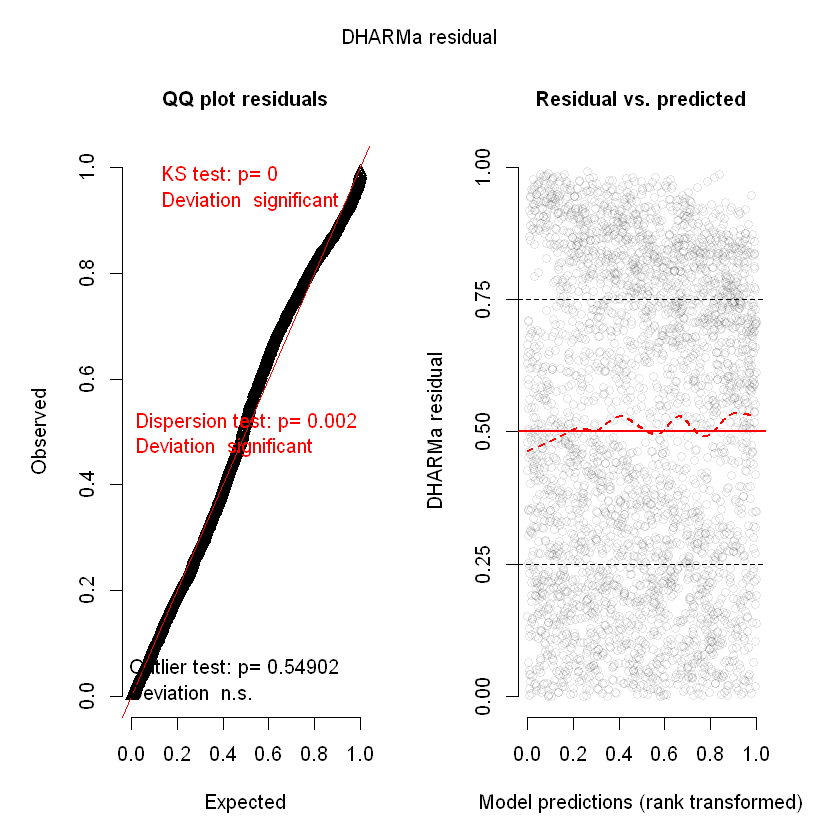

In [14]:
set.seed(1234)
mod_ = rpt(cbind(perc_1_Zone_while_WG_open, perc_NOT1_Zone_while_WG_open) ~ time + time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID),
               grname=c("HenID"), datatype = "Proportion", data=df, adjusted =TRUE, nboot = nboot_, npermut = npermut_) 
mod_
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)

Bootstrap Progress:


Repeatability estimation using the glmm method and logit link 

Repeatability for HenID
--------------------------------
Link-scale approximation:
R  = 0.178
SE = 0.032
CI = [0.107, 0.225]
P  = 3.54e-87 [LRT]
     NA [Permutation]

Original-scale approximation:
R  = 0.171
SE = 0.029
CI = [0.105, 0.212]
P  = 3.54e-87 [LRT]
     NA [Permutation]



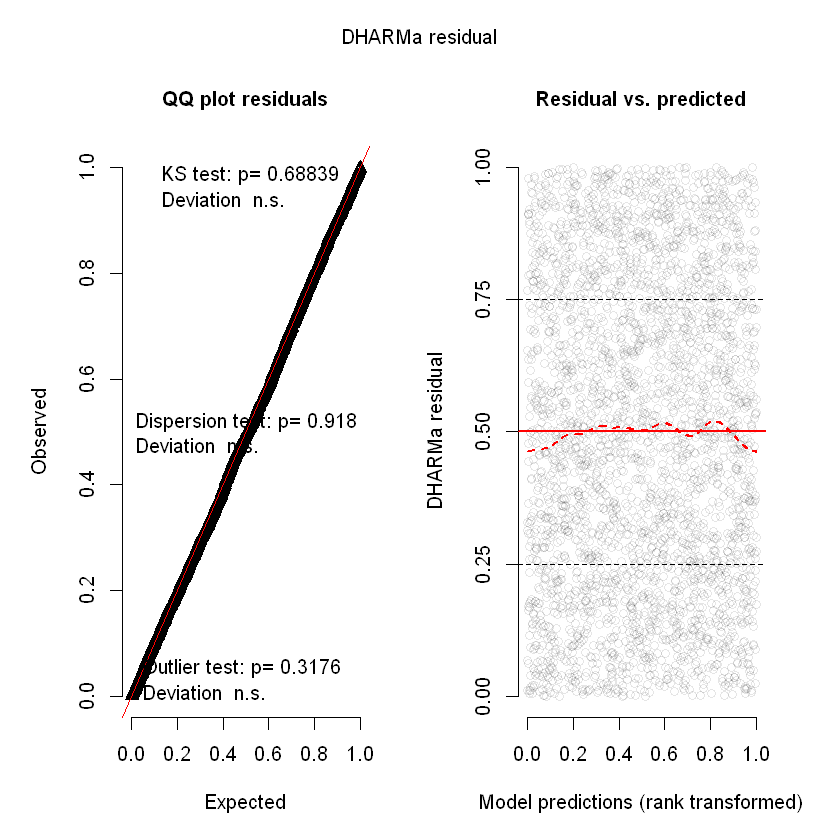

In [41]:
#sometimes does not cvg with time2, so I removed it
set.seed(1234)
mod_ = rpt(SleepingDown ~ time + time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID), 
                       grname = c("HenID"), data = df, datatype = "Binary", link = "logit", adjusted =TRUE,
                       nboot = nboot_, npermut = 0)
print(mod_)
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)

### nbr boots in zone 4

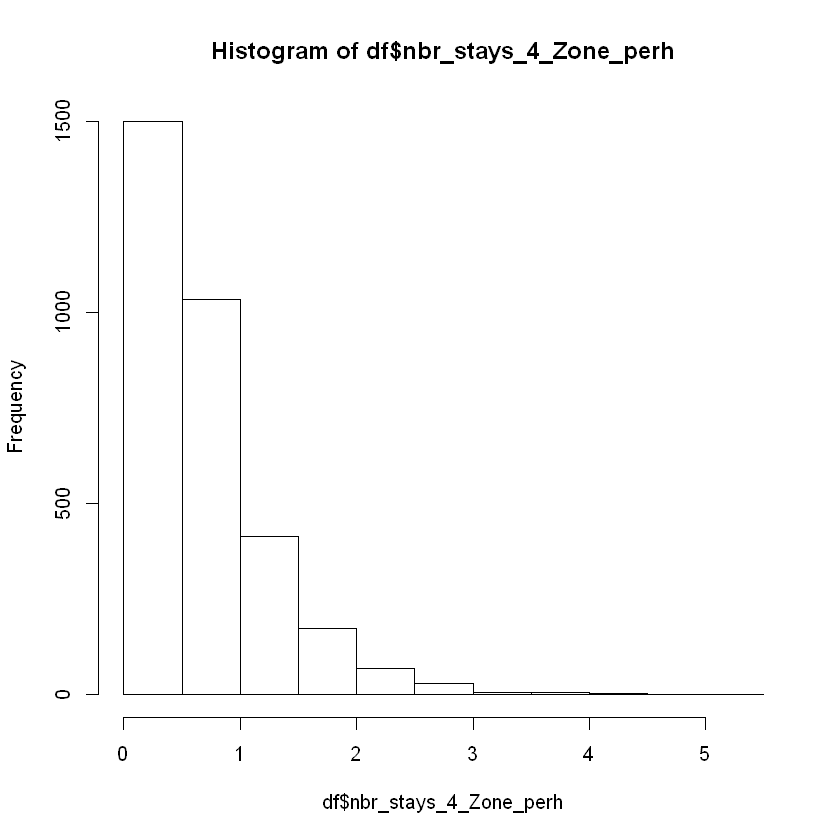

In [17]:
hist(df$nbr_stays_4_Zone_perh)

In [ ]:
df$nbr_stays_4_Zone_perh

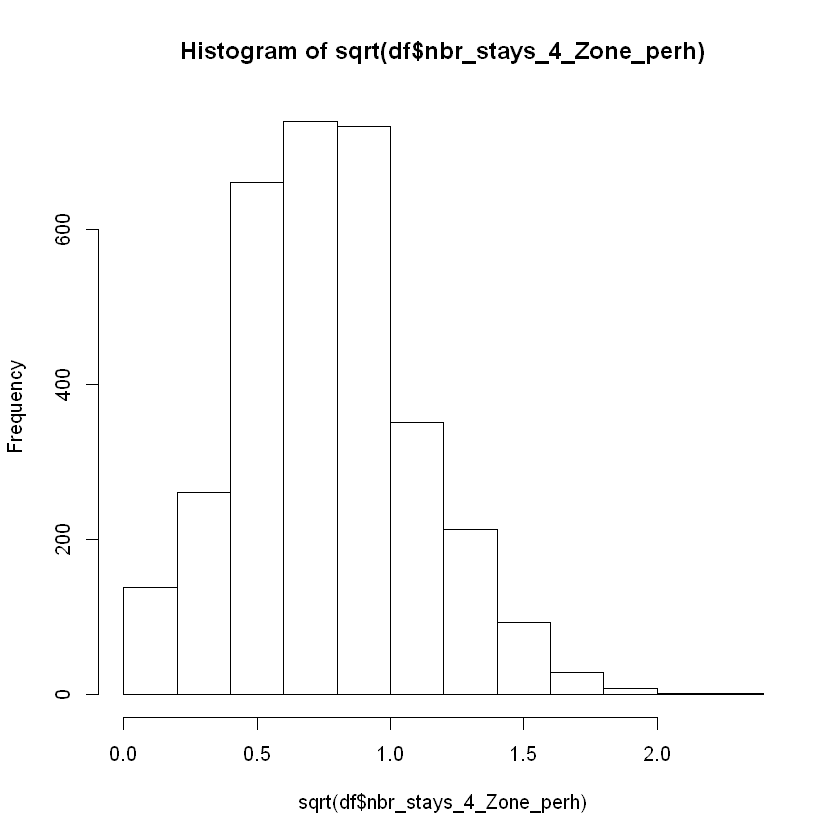

In [18]:
hist(sqrt(df$nbr_stays_4_Zone_perh))

Bootstrap Progress:
Permutation Progress for HenID :


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.269
SE = 0.035
CI = [0.19, 0.326]
P  = 1.09e-166 [LRT]
     0.5 [Permutation]



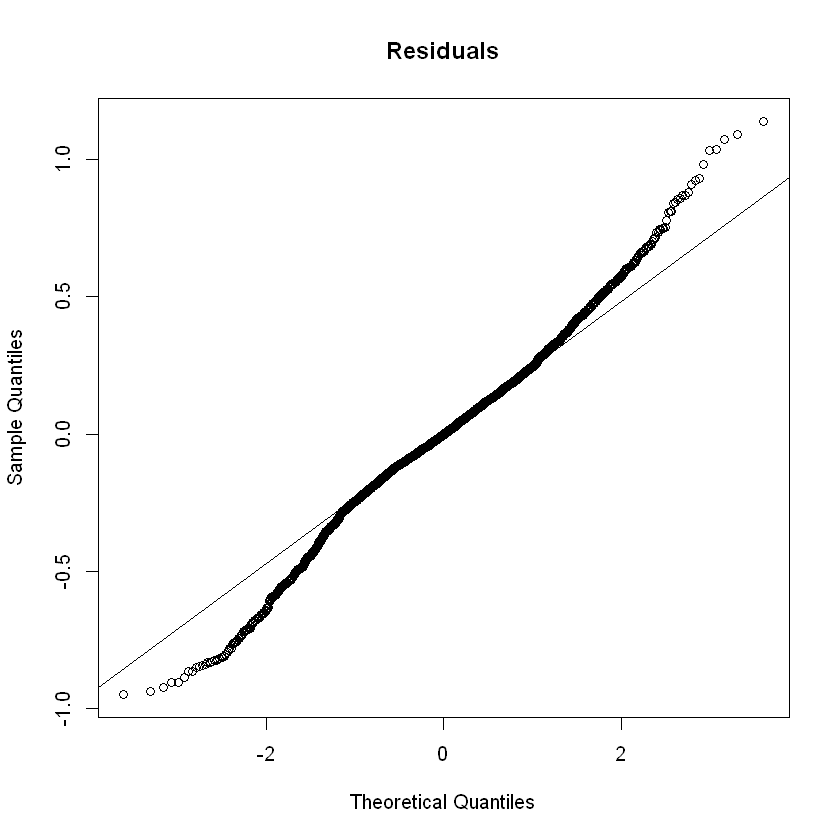

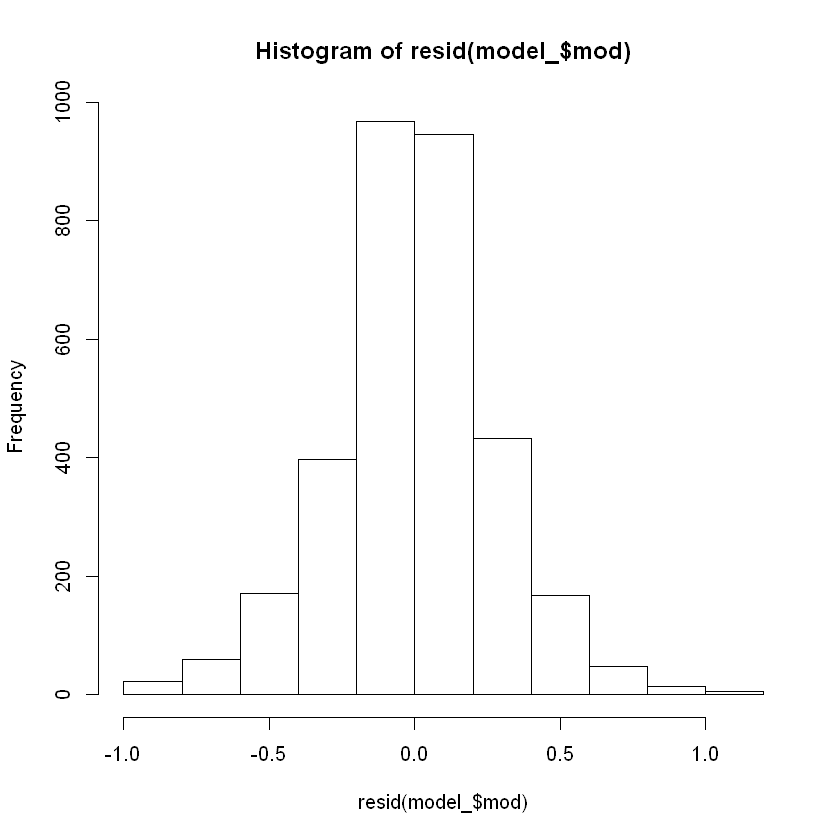

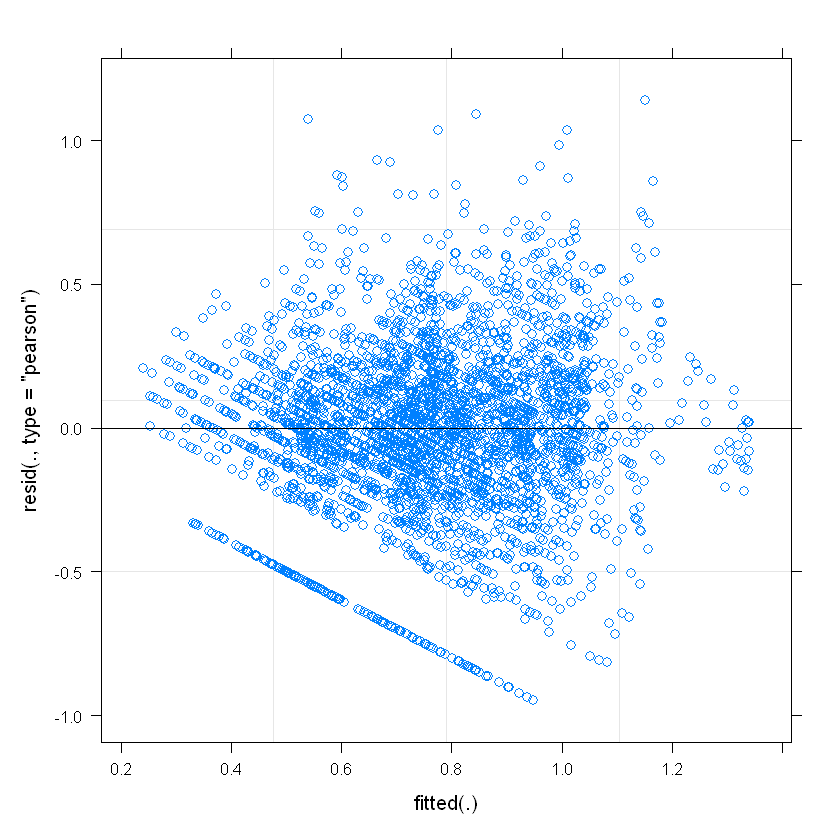

In [19]:
set.seed(1234)
model_ = rpt(sqrt(nbr_stays_4_Zone_perh) ~ time + time2 + avgDIB_scale + Treatment + InitialWeight_scale + (1|HenID),
               grname=c("HenID"), datatype = "Gaussian", data=df, adjusted =TRUE, nboot = nboot_, npermut = npermut_) 
print(model_)
#par(mfrow = c(2, 2))
###### normally distributed residuals
qqnorm(resid(model_$mod), main = "Residuals")
qqline(resid(model_$mod))
hist(resid(model_$mod))
######check homogeneity of variance (residuals has constant variance)
#variance of the residuals is equal across groups. Even spread around the centered line?
plot(model_$mod)